In [1]:
"""

MACD (Moving Average Convergence Divergence) strategy:
- Buys when MACD crosses above the Signal line
- Sells when MACD crosses below the Signal line

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def download_data(ticker="BTC-USD", start="2021-01-01", end="2023-01-01"):
    df = yf.download(ticker, start=start, end=end, progress=False)
    df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    }, inplace=True)
    df.dropna(inplace=True)
    return df

In [2]:
def macd_signals(df, fast=12, slow=26, signal=9):
    """
    MACD = EMA(fast) - EMA(slow)
    signal line = EMA(MACD, signal_period)
    """
    df['ema_fast'] = df['close'].ewm(span=fast, adjust=False).mean()
    df['ema_slow'] = df['close'].ewm(span=slow, adjust=False).mean()
    df['macd'] = df['ema_fast'] - df['ema_slow']
    df['signal_line'] = df['macd'].ewm(span=signal, adjust=False).mean()
    
    df['signal'] = 0
    df.loc[df['macd'] > df['signal_line'], 'signal'] = 1
    df.loc[df['macd'] < df['signal_line'], 'signal'] = -1
    return df

In [3]:

def backtest_strategy(df, initial_capital=10000):
    df['returns'] = df['close'].pct_change().fillna(0)
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']
    df['cumulative_market'] = (1 + df['returns']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()
    
    final_value = initial_capital * df['cumulative_strategy'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital

    drawdown = (
        (df['cumulative_strategy'].cummax() - df['cumulative_strategy'])
        / df['cumulative_strategy'].cummax()
    )
    max_drawdown = drawdown.max()
    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    
    result = {
        "Initial Capital": initial_capital,
        "Final Portfolio Value": round(final_value, 2),
        "Total Return": f"{total_return*100:.2f}%",
        "Max Drawdown": f"{max_drawdown*100:.2f}%",
        "Sharpe Ratio": round(sharpe_ratio, 2)
    }
    return df, result

In [4]:
def plot_results(df):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
    
    ax[0].plot(df.index, df['close'], label='Price')
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    ax[0].scatter(buy_signals.index, buy_signals['close'], marker='^', label='Buy')
    ax[0].scatter(sell_signals.index, sell_signals['close'], marker='v', label='Sell')
    ax[0].legend()
    ax[0].set_title("MACD Trend Strategy - Price & Signals")
    
    ax[1].plot(df.index, df['macd'], label='MACD')
    ax[1].plot(df.index, df['signal_line'], label='Signal')
    ax[1].legend()
    ax[1].set_title("MACD & Signal Line")
    plt.show()
    
    # Equity Curve
    plt.plot(df.index, df['cumulative_market'], label='Market Returns')
    plt.plot(df.index, df['cumulative_strategy'], label='Strategy Returns')
    plt.title("MACD Trend Strategy - Equity Curve")
    plt.legend()
    plt.show()

YF.download() has changed argument auto_adjust default to True
Performance Metrics:
Initial Capital: 10000
Final Portfolio Value: 9537.14
Total Return: -4.63%
Max Drawdown: 61.11%
Sharpe Ratio: 0.27


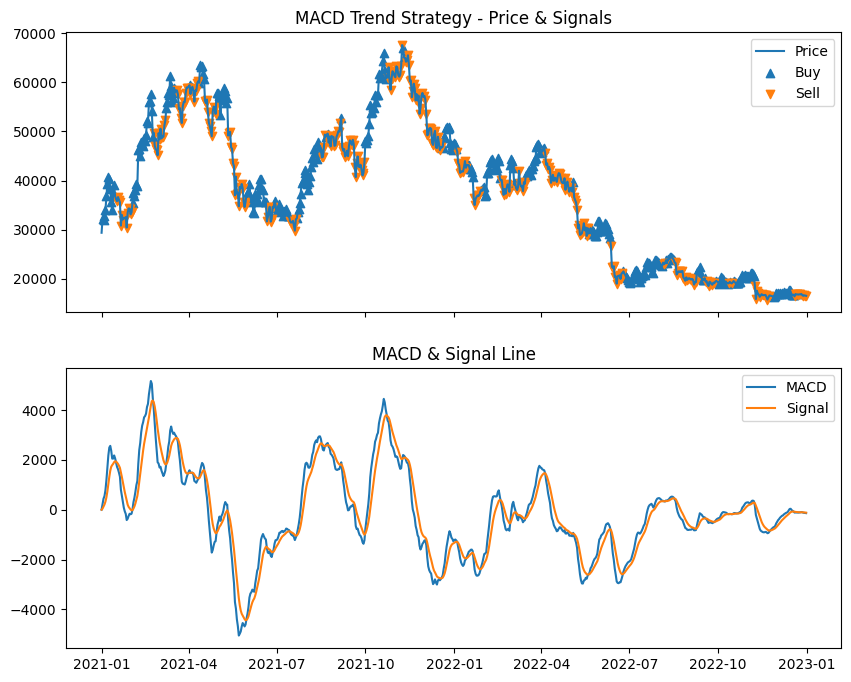

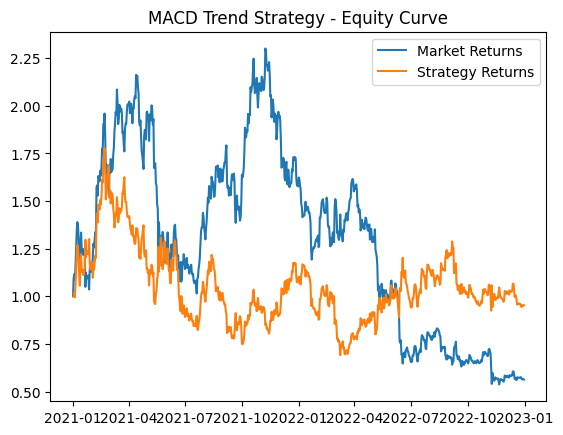

In [5]:
data = download_data("BTC-USD", "2021-01-01", "2023-01-01")
data = macd_signals(data, fast=12, slow=26, signal=9)
data, metrics = backtest_strategy(data)

print("Performance Metrics:")
for k,v in metrics.items():
    print(f"{k}: {v}")

plot_results(data)